In [29]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
# from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [30]:
CLASSES: dict[int, str] = {
    -1: "None",
    0: "Spam/Scam/Garbage",
    1: "Non-Complaint ",
    # -- Rest are complaints --
    2: "Delay",
    3: "Hygeine (food, toilets, carriage)",
    4: "Ticket issue (cancellation, refund, seat change)",
    5: "Medical issue",
    6: "Safety issue",
    7: "Travel Experience",
    8: "Feedback / Suggestions (less critical/urgent)",
}
URGENCY: dict[int, str] = {
    -1: "None",
    0: "Low",
    1: "Pressing",
    2: "critical",
}
LANG: dict[int, str] = {
    -1: "None",
    0: "English",
    1: "Hindi (devanagari; purely)",
    2: "Hinglish (devanagari; with english in latin alphabet)",
    3: "Hinglish (devanagari; with english transliterated to hindi)",
    4: "Hinglish (latin; with hindi transliterated to english)",
}

### Training the complaint/non-complaint differentiator model

In [31]:
df_cnc = pd.read_csv('./eng_data_cnc.csv')

print(df_cnc['label'].value_counts())
print(len(df_cnc["SentimentText"].tolist()))

label
1    1500
0     696
Name: count, dtype: int64
2196


Empty string is saved as NaN (float), convert it back to empty string

In [32]:
for idx, i in enumerate(df_cnc.loc[:, "SentimentText"]):
    if type(i) == float:
        df_cnc.loc[idx, "SentimentText"] = ""

In [33]:
import time
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_cnc['SentimentText'].tolist(), df_cnc['label'].tolist(), test_size=0.2, random_state=(time.time_ns() % 943024), stratify=df_cnc['label']
)

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [35]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [36]:
train_dataset[0]

{'input_ids': tensor([  101,  5310,  8909,  1024, 26632, 16584,  3058,  1997, 21725,  1024,
          1026,  3058,  1028,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(0)}

In [37]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [38]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 4
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Training loop
model.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    pbar = tqdm(train_loader, desc="Training")
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        pbar.set_postfix(loss=loss.item())


Epoch 1/4


Training: 100%|██████████| 55/55 [00:44<00:00,  1.24it/s, loss=0.449]



Epoch 2/4


Training: 100%|██████████| 55/55 [00:44<00:00,  1.22it/s, loss=0.322]



Epoch 3/4


Training: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, loss=0.0387]



Epoch 4/4


Training: 100%|██████████| 55/55 [00:45<00:00,  1.22it/s, loss=0.0366]


In [39]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Results
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Complaint", "Complaint"]))
print("Accuracy:", accuracy_score(all_labels, all_preds))

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]


Classification Report:
               precision    recall  f1-score   support

Non-Complaint       0.86      0.77      0.81       139
    Complaint       0.90      0.94      0.92       301

     accuracy                           0.89       440
    macro avg       0.88      0.85      0.86       440
 weighted avg       0.89      0.89      0.88       440

Accuracy: 0.8863636363636364


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Results
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Complaint", "Complaint"]))
print("Accuracy:", accuracy_score(all_labels, all_preds))

# Classification Report:
#                precision    recall  f1-score   support

# Non-Complaint       0.74      0.68      0.71       139
#     Complaint       0.86      0.89      0.87       301

#      accuracy                           0.82       440
#     macro avg       0.80      0.79      0.79       440
#  weighted avg       0.82      0.82      0.82       440

# Accuracy: 0.8227272727272728

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]


Classification Report:
               precision    recall  f1-score   support

Non-Complaint       0.74      0.73      0.74       139
    Complaint       0.88      0.88      0.88       301

     accuracy                           0.83       440
    macro avg       0.81      0.81      0.81       440
 weighted avg       0.83      0.83      0.83       440

Accuracy: 0.8340909090909091


In [27]:
# %pip -q install seaborn

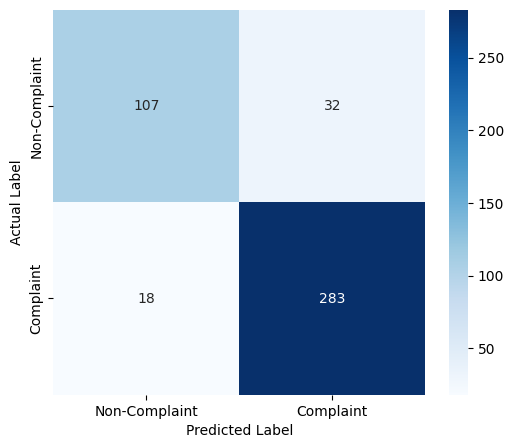

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ["Non-Complaint", "Complaint"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
# plt.title("Confusion Matrix")
plt.show()

In [42]:
model.save_pretrained("bert_complaint_classifier")
tokenizer.save_pretrained("bert_complaint_classifier")

import pickle
with open('val_labels.pkl', 'wb') as file:
    pickle.dump(val_labels, file)
with open('val_texts.pkl', 'wb') as file:
    pickle.dump(val_texts, file)

In [15]:
import gc

In [27]:
try: model.cpu()
except: pass

try: del model
except: pass

try: del optimizer
except: pass

try: del lr_scheduler
except: pass

try:
    with torch.no_grad():
        torch.cuda.empty_cache()
except: pass

try: del torch
except: pass

try: del AdamW
except: pass

try: del tqdm
except: pass

try: del Dataset, DataLoader
except: pass


gc.collect()

693

In [28]:
! nvidia-smi

Sat May 10 15:57:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| N/A   77C    P0             N/A / 5001W |     459MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModel, AutoTokenizer, AutoConfig
# from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import re, pickle

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert_complaint_classifier")
tokenizer = AutoTokenizer.from_pretrained("bert_complaint_classifier")

In [ ]:
model.to(device)

BERTBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
with open('val_texts.pkl', 'rb') as file:
    val_texts = pickle.load(file)
print(val_texts)
with open('val_labels.pkl', 'rb') as file:
    val_labels = pickle.load(file)
print(val_labels)

['my oldagd mother trvlng wht 2 child . in magadheprss from pnbe to ndls . . out of communication last 10 hours . please hlp', 'kindly conduct routine ticket checking passenger train between saharanpur to delhi . via meerut . lost of people without ticket', 'sir ples allot wdp4 loco of 19027 bandra jamu tawi vivek express . from adi to jat . ples allot .', '. 2 a seats 3,4 , 5,6 . ticket printed as 2 lower berth 2 upper berth on tickets but in 2 air conditioner 5 and 6 are side seats . is that possible ?', 'i was expecting some strict action on overcharging but instead received a mail stating counseling will be done for them .', 'trying to book a tatkal ticket from last 3 day but daily same problem exist . please do some needful', 'sir condition of railway colony bareilly junction . for past 5 days . please help', 'kinly help with irctc refund doing follow up with irctc since 2 4th may .', 'need some help in teain number 12192 as our bag was stolen and no police is available to file a 

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    val_preds, val_targets = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    return (val_targets, val_preds)

(val_targets, val_preds) = evaluate(model, val_loader)

In [ ]:
labels = ["Non-Complaint", "Complaint"]

{-2: 'None',
 -1: 'Spam/Scam/Garbage',
 0: 'Non-Complaint ',
 1: 'Delay',
 2: 'Hygeine (food, toilets, carriage)',
 3: 'Ticket issue (cancellation, refund, seat change)',
 4: 'Medical issue',
 5: 'Safety issue',
 6: 'Travel Experience',
 7: 'Feedback / Suggestions (less critical/urgent)'}

In [ ]:
print("\nClassification Report:")
print(classification_report(val_targets, val_preds, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

         Low       0.67      0.66      0.67       143
    Pressing       0.56      0.64      0.60       130
    Critical       0.45      0.19      0.26        27

    accuracy                           0.61       300
   macro avg       0.56      0.50      0.51       300
weighted avg       0.61      0.61      0.60       300



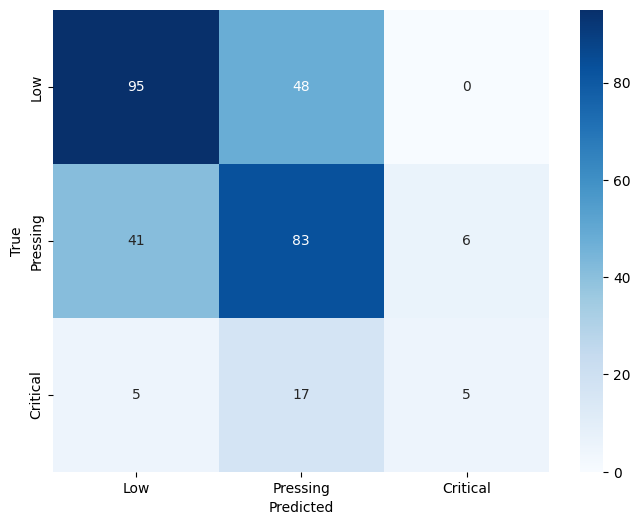

In [ ]:
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.title('Confusion Matrix')
plt.show()

In [ ]:
import gc
try: model.cpu()
except: pass

try: del model
except: pass

try: del optimizer
except: pass

try: del lr_scheduler
except: pass

try:
    with torch.no_grad():
        torch.cuda.empty_cache()
except: pass

try: del torch
except: pass

try: del tqdm
except: pass

try: del Dataset, DataLoader, nn, AdamW
except: pass


gc.collect()

4307